In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

# Generate plots inline
%matplotlib inline

import os

# Target Connectivity

## Board specific settings

Boards specific settings can be collected into a JSON
platform description file:

In [2]:
!ls -la $LISA_HOME/libs/utils/platforms/

total 32
drwxrwxr-x 2 derkling derkling 4096 Sep 23 12:12 .
drwxrwxr-x 5 derkling derkling 4096 Sep 23 15:58 ..
-rw------- 1 derkling derkling  896 Sep 23 12:12 hikey.json
-rw-rw-r-- 1 derkling derkling  468 Jan 22  2016 juno.json
-rw-rw-r-- 1 derkling derkling  427 Aug 24 12:52 marlin.json
-rw-rw-r-- 1 derkling derkling  176 Aug 31 12:18 nexus5x.json
-rw-rw-r-- 1 derkling derkling  473 Feb  2  2016 oak.json
-rw-rw-r-- 1 derkling derkling  473 Jan 22  2016 tc2.json


In [3]:
!cat $LISA_HOME/libs/utils/platforms/hikey.json

{
	// HiKey boards have two SMP clusters
	// Even being an SMP platform, being a two cluster system
	// we can still load the devlib's bl module to get access
	// to all the per-cluster functions it exposes
	"board" : {
		"cores" : [
			"A53_0", "A53_0", "A53_0", "A53_0",
			"A53_1", "A53_1", "A53_1", "A53_1"
		],
		"big_core" : "A53_1",
		"modules"  : [ "bl", "cpufreq" ]
	},

	// Energy Model related functions requires cluster
	// to be named "big.LITTLE". Thus, for the time being,
	// let's use this naming also for HiKey. This is going
	// to be updated once we introduce proper SMP and
	// multi-cluster support.
	"nrg_model": {
		"little": {
			"cluster": {
				"nrg_max": 112
			},
			"cpu": {
				"nrg_max":  670, "cap_max": 1024
			}
		},
		"big": {
			"cluster": {
				"nrg_max": 112
			},
			"cpu": {
				"nrg_max":  670,
				"cap_max": 1024
			}
		}
	}

}

// vim: set tabstop=4:


## Single configuration dictionary

In [2]:
# Check which Android devices are available
!adb devices

List of devices attached
00b43d0b08a8a4b8	device
607A87C400055E6E	device



In [3]:
ADB_DEVICE = '00b43d0b08a8a4b8'

In [6]:
# Unified configuration dictionary
my_conf = {

    # Target platform
    "platform"    : 'android',

    # Location of external tools (adb, fastboot, systrace, etc)
    # These properties can be used to override the environment variables:
    # ANDROID_HOME and CATAPULT_HOME
    "ANDROID_HOME"  : "/opt/android-sdk-linux",
    "CATAPULT_HOME" : "/home/derkling/Code/catapult",

    # Boards specific settings can be collected into a JSON
    # platform description file, to be placed under:
    # LISA_HOME/libs/utils/platforms
    "board"       : 'hikey',
    
    # If you have multiple Android device connected, here
    # we can specify which one to target
    "device"      : ADB_DEVICE,

    # Folder where all the results will be collected
    "results_dir" : "ReleaseNotes_v16.09",
}

In [7]:
from env import TestEnv

te = TestEnv(my_conf, force_new=True)
target = te.target

2016-09-23 18:26:53,404 INFO    :         Target - Using base path: /home/derkling/Code/lisa
2016-09-23 18:26:53,404 INFO    :         Target - Loading custom (inline) target configuration
2016-09-23 18:26:53,404 INFO    :         Target - External tools using:
2016-09-23 18:26:53,405 INFO    :         Target -    ANDROID_HOME: /opt/android-sdk-linux
2016-09-23 18:26:53,405 INFO    :         Target -    CATAPULT_HOME: /home/derkling/Code/lisa/tools/catapult
2016-09-23 18:26:53,405 INFO    :       Platform - Loading board:
2016-09-23 18:26:53,405 INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/platforms/hikey.json
2016-09-23 18:26:53,406 INFO    :         Target - Devlib modules to load: [u'bl', u'cpufreq']
2016-09-23 18:26:53,406 INFO    :         Target - Connecting Android target [607A87C400055E6E]
2016-09-23 18:26:53,406 INFO    :         Target - Connection settings:
2016-09-23 18:26:53,406 INFO    :         Target -    {'device': '607A87C400055E6E'}
2016-09-23 18

# Energy Meters Support

- Simple unified interface for multiple acquisition board
    - exposes two simple methods: **reset()** and **report()**
    - reporting **energy** consumptions
    - reports additional info supported by the specific probe,<br>
      e.g. collected samples, stats on current and voltages, etc.

In [8]:
from time import sleep

def sample_energy(energy_meter, time_s):
    
    # Reset the configured energy counters
    energy_meter.reset()

    # Run the workload you want to measure
    #
    # In this simple example we just wait some time while the
    # energy counters accumulate power samples
    sleep(time_s)

    # Read and report the measured energy (since last reset)
    return energy_meter.report(te.res_dir)

- Channels mapping support
    - allows to give a custom name to each channel used

## ARM Energy Probe (AEP)

Requirements:
1. the **caimin binary tool** must be availabe in PATH<br>
   https://github.com/ARM-software/lisa/wiki/Energy-Meters-Requirements#arm-energy-probe-aep
2. the **ttyACMx device** created once you plug in the AEP device

In [15]:
!ls -la /dev/ttyACM*

crw-rw---- 1 root dialout 166, 1 Sep 23 18:28 /dev/ttyACM1


In [16]:
ACM_DEVICE = '/dev/ttyACM1'

### Direct usage

In [17]:
# Energy Meters Configuration for ARM Energy Probe
aep_conf = {
    'conf' : {
        # Value of the shunt resistor [Ohm] for each channel
        'resistor_values' : [0.010],
        # Device entry assigned to the probe on the host
        'device_entry'    : ACM_DEVICE,
    },
    'channel_map' : {
            'BAT' : 'CH0'
    }
}

from energy import AEP
ape_em = AEP(target, aep_conf, '/tmp')

2016-09-23 18:28:22,422 INFO    :            AEP - AEP configuration
2016-09-23 18:28:22,422 INFO    :            AEP -     {'channel_map': {'BAT': 'CH0'}, 'conf': {'resistor_values': [0.01], 'device_entry': '/dev/ttyACM1'}}
2016-09-23 18:28:22,472 INFO    :            AEP - Channels selected for energy sampling:
[CHAN(BAT_current), CHAN(BAT_power), CHAN(BAT_voltage)]


In [18]:
nrg_report = sample_energy(ape_em, 2)
print nrg_report

EnergyReport(channels={'BAT': 0.00341733929419313}, report_file='/home/derkling/Code/lisa/results/ReleaseNotes_v16.09/energy.json')


In [19]:
!cat $nrg_report.report_file

{
    "BAT": 0.00341733929419313
}

### Usage via TestEnv

In [43]:
my_conf = {

    # Configure the energy meter to use
    "emeter" : {
        
        # Require usage of an AEP meter
        "instrument" : "aep",
        
        # Configuration parameters require by the AEP device
        "conf" : {
            # Value of the shunt resistor in Ohm
            'resistor_values' : [0.099],
            # Device entry assigned to the probe on the host
            'device_entry'    : ACM_DEVICE,
        },
        
        # Map AEP's channels to logical names (used to generate reports)
        'channel_map' : {
            'BAT' : 'CH0'
        }
    },

    # Other target configurations
    "platform"      : 'android',
    "board"         : 'hikey',
    "device"        : ADB_DEVICE,
    "results_dir"   : "ReleaseNotes_v16.09",
    "ANDROID_HOME"  : "/opt/android-sdk-linux",
    "CATAPULT_HOME" : "/home/derkling/Code/catapult",
}

In [46]:
from env import TestEnv

te = TestEnv(my_conf, force_new=True)

2016-09-23 18:53:00,113 INFO    :         Target - Using base path: /home/derkling/Code/lisa
2016-09-23 18:53:00,113 INFO    :         Target - Loading custom (inline) target configuration
2016-09-23 18:53:00,113 INFO    :         Target - External tools using:
2016-09-23 18:53:00,114 INFO    :         Target -    ANDROID_HOME: /opt/android-sdk-linux
2016-09-23 18:53:00,114 INFO    :         Target -    CATAPULT_HOME: /home/derkling/Code/lisa/tools/catapult
2016-09-23 18:53:00,114 INFO    :       Platform - Loading board:
2016-09-23 18:53:00,115 INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/platforms/hikey.json
2016-09-23 18:53:00,116 INFO    :         Target - Devlib modules to load: [u'bl', u'cpufreq']
2016-09-23 18:53:00,116 INFO    :         Target - Connecting Android target [00b43d0b08a8a4b8]
2016-09-23 18:53:00,117 INFO    :         Target - Connection settings:
2016-09-23 18:53:00,118 INFO    :         Target -    {'device': '00b43d0b08a8a4b8'}
2016-09-23 18

In [ ]:
for i in xrange(1,11):
    nrg_report = sample_energy(te.emeter, 1)
    nrg_bat = float(nrg_report.channels['BAT'])
    print "Sample {:2d}: {:.3f}".format(i, nrg_bat)

## BayLibre's ACME board (ACME)

Requirements:
1. the **iio-capture tool** must be available in PATH<br>
   https://github.com/ARM-software/lisa/wiki/Energy-Meters-Requirements#iiocapture---baylibre-acme-cape
2. the ACME CAPE should be reacable by network

In [22]:
!ping -c1 baylibre-acme.local | grep '64 bytes'

64 bytes from 192.168.0.1: icmp_seq=1 ttl=64 time=1.60 ms


### Direct usage

In [23]:
# Energy Meters Configuration for BayLibre's ACME
acme_conf = {
        "conf" : {
            #'iio-capture' : '/usr/bin/iio-capture',
            #'ip_address' : 'baylibre-acme.local',
        },
        "channel_map" : {
            "Device0" : 0,
            "Device1" : 1,
        },
}

from energy import ACME
acme_em = ACME(target, acme_conf, '/tmp')

2016-09-23 18:49:31,422 INFO    :           ACME - ACME configuration:
2016-09-23 18:49:31,422 INFO    :           ACME -     binary: iio-capture
2016-09-23 18:49:31,422 INFO    :           ACME -     device: baylibre-acme.local
2016-09-23 18:49:31,423 INFO    :           ACME -   channels:
2016-09-23 18:49:31,423 INFO    :           ACME -      Device1 (iio:device1)
2016-09-23 18:49:31,423 INFO    :           ACME -      Device0 (iio:device0)


In [24]:
nrg_report = sample_energy(acme_em, 2)
print nrg_report

EnergyReport(channels={'Device1': 654.82, 'Device0': 0.0}, report_file='/home/derkling/Code/lisa/results/ReleaseNotes_v16.09/energy.json')


In [25]:
!cat $nrg_report.report_file

{
    "Device0": 0.0, 
    "Device1": 654.82
}

### Usage via TestEnv

In [4]:
my_conf = {

    # Configure the energy meter to use
    "emeter" : {
        
        # Require usage of an AEP meter
        "instrument" : "acme",
        
        "conf" : {
            #'iio-capture' : '/usr/bin/iio-capture',
            #'ip_address' : 'baylibre-acme.local',
        },
        'channel_map' : {
            'Device0' : 0,
            'Device1' : 1,
        },
    },

    # Other target configurations
    "platform"      : 'android',
    "board"         : 'hikey',
    "device"        : ADB_DEVICE,
    "results_dir"   : "ReleaseNotes_v16.09",
    "ANDROID_HOME"  : "/opt/android-sdk-linux",
    "CATAPULT_HOME" : "/home/derkling/Code/catapult",
}

In [5]:
from env import TestEnv

te = TestEnv(my_conf, force_new=True)
target = te.target

2016-09-23 18:54:37,835 INFO    :         Target - Using base path: /home/derkling/Code/lisa
2016-09-23 18:54:37,835 INFO    :         Target - Loading custom (inline) target configuration
2016-09-23 18:54:37,836 INFO    :         Target - External tools using:
2016-09-23 18:54:37,836 INFO    :         Target -    ANDROID_HOME: /opt/android-sdk-linux
2016-09-23 18:54:37,836 INFO    :         Target -    CATAPULT_HOME: /home/derkling/Code/lisa/tools/catapult
2016-09-23 18:54:37,837 INFO    :       Platform - Loading board:
2016-09-23 18:54:37,837 INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/platforms/hikey.json
2016-09-23 18:54:37,838 INFO    :         Target - Devlib modules to load: [u'bl', u'cpufreq']
2016-09-23 18:54:37,838 INFO    :         Target - Connecting Android target [00b43d0b08a8a4b8]
2016-09-23 18:54:37,839 INFO    :         Target - Connection settings:
2016-09-23 18:54:37,839 INFO    :         Target -    {'device': '00b43d0b08a8a4b8'}
2016-09-23 18

In [28]:
for i in xrange(1,11):
    nrg_report = sample_energy(te.emeter, 1)
    nrg_bat = float(nrg_report.channels['Device1'])
    print "Sample {:2d}: {:.3f}".format(i, nrg_bat)

Sample  1: 342.110
Sample  2: 325.660
Sample  3: 324.120
Sample  4: 369.300
Sample  5: 331.140
Sample  6: 315.130
Sample  7: 326.100
Sample  8: 345.180
Sample  9: 328.730
Sample 10: 328.510


# Android Integration

A new Android library has been added which provides APIs to:
    - simplify the interaction with a device
    - execute interesting workloads and benchmarks
    - make it easy the integration of new workloads and benchmarks
    
Not intended to replace WA, but instead to provide a Python based<br>
programming interface to **automate reproducible experiments** on<br>
and Android device.

## System control APIs

In [6]:
from android import System

print "Supported functions:"
for f in dir(System):
    if "__" in f:
        continue
    print "   ", f

Supported functions:
    back
    force_stop
    gfxinfo_get
    gfxinfo_reset
    home
    hswipe
    list_packages
    menu
    monkey
    packages_info
    set_airplane_mode
    start_action
    start_activity
    start_app
    tap
    vswipe


Capturing main useful actions, for example:
    - ensure we set AIRPLAIN_MODE before measuring scheduler energy
    - provide simple support for input actions (relative swipes)

In [34]:
# logging.getLogger().setLevel(logging.DEBUG)

In [ ]:
# Example (use tab to complete)
System.

In [7]:
System.menu(target)
System.back(target)

In [8]:
youtube_apk = System.list_packages(target, 'YouTube')
if youtube_apk:
    System.start_app(target, youtube_apk[0])

In [45]:
logging.getLogger().setLevel(logging.INFO)

## Screen control APIs

In [9]:
from android import Screen

print "Supported functions:"
for f in dir(Screen):
    if "__" in f:
        continue
    print "   ", f

Supported functions:
    set_brightness
    set_defaults
    set_dim
    set_orientation
    set_timeout


In [ ]:
# logging.getLogger().setLevel(logging.DEBUG)

In [ ]:
# Example (use TAB to complete)
Screen.

In [10]:
Screen.set_brightness(target, auto=False, percent=100)

2016-09-23 18:55:19,490 INFO    : Set brightness: 100%


In [11]:
Screen.set_orientation(target, auto=False, portrait=False)

2016-09-23 18:55:19,494 INFO    : Force manual orientation
2016-09-23 18:55:19,494 INFO    : Set orientation: LANDSCAPE


In [ ]:
# logging.getLogger().setLevel(logging.INFO)

## Workloads Execution

A simple workload class allows to easily add a wrapper for the exection
of a specific Android application.

**NOTE:** To keep things simple, LISA does not provide APKs installation support.

*All the exposes APIs assume that the required packages are already installed<br>
in the target. Whenever a package is missing, LISA reports that and it's up<br>
to the user to install it before using it.*

A wrapper class usually requires to specify:
- a package name<br>
  which will be used to verify if the APK is available in the target
- a run method<br>
  which usually exploits the other Android APIs to defined a **reproducible
  exection** of the specified workload
      
A reproducible experiment should take care of:
- setups wirelesse **connections status**
- setup **screen orientation and backlight** level
- properly collect **energy measurements** across the sensible part of the experiment
- possibly collect **frames statistics** whenever available

### Example of YouTube integration

Here is an example wrapper which allows to play a YouTube<br>
video for a specified number of seconds:

https://github.com/ARM-software/lisa/blob/master/libs/utils/android/workloads/youtube.py

### Example usage of the Workload API

In [40]:
# logging.getLogger().setLevel(logging.DEBUG)

In [12]:
from android import Workload

# Get the list of available workloads
wloads = Workload(te)
wloads.availables(target)

2016-09-23 18:55:25,384 WARNING :       Workload - Package [com.android.benchmark] not installed
2016-09-23 18:55:25,385 WARNING :       Workload - Workload [Jankbench] disabled
2016-09-23 18:55:25,385 INFO    :       Workload - Workloads available on target:
2016-09-23 18:55:25,385 INFO    :       Workload -   ['YouTube', 'UiBench']


['YouTube', 'UiBench']

In [16]:
yt = Workload.get(te, name='YouTube')

# Playback big bug bunny for 15s starting from 1:20s
video_id = 'XSGBVzeBUbk'
video_url = "https://youtu.be/{}?t={}s".format(video_id, 80)

# Play video and measure energy consumption
results = yt.run(te.res_dir,
                 video_url, video_duration_s=16,
                 collect='energy')

2016-09-23 18:55:58,229 INFO    :       Workload - Workloads available on target:
2016-09-23 18:55:58,230 INFO    :       Workload -   ['YouTube', 'UiBench']
2016-09-23 18:56:00,090 INFO    : Force manual orientation
2016-09-23 18:56:00,091 INFO    : Set orientation: LANDSCAPE
2016-09-23 18:56:05,068 INFO    : Play video for 16 [s]
2016-09-23 18:56:27,121 INFO    : Set orientation: AUTO


In [17]:
results

('/home/derkling/Code/lisa/results/ReleaseNotes_v16.09/framestats.txt',
 EnergyReport(channels={'Device1': 4363.82, 'Device0': 0.0}, report_file='/home/derkling/Code/lisa/results/ReleaseNotes_v16.09/energy.json'))

In [18]:
framestats = results[0]
!cat $framestats

Applications Graphics Acceleration Info:
Uptime: 135646296 Realtime: 248599085

** Graphics info for pid 23414 [com.google.android.youtube] **

Stats since: 135590611534135ns
Total frames rendered: 342
Janky frames: 59 (17.25%)
50th percentile: 8ms
90th percentile: 21ms
95th percentile: 40ms
99th percentile: 125ms
Number Missed Vsync: 21
Number High input latency: 0
Number Slow UI thread: 27
Number Slow bitmap uploads: 2
Number Slow issue draw commands: 28
HISTOGRAM: 5ms=70 6ms=32 7ms=35 8ms=38 9ms=31 10ms=21 11ms=21 12ms=14 13ms=10 14ms=7 15ms=3 16ms=4 17ms=3 18ms=3 19ms=7 20ms=4 21ms=7 22ms=0 23ms=3 24ms=1 25ms=2 26ms=2 27ms=1 28ms=0 29ms=2 30ms=0 31ms=0 32ms=0 34ms=2 36ms=0 38ms=0 40ms=2 42ms=0 44ms=0 46ms=2 48ms=1 53ms=2 57ms=2 61ms=0 65ms=1 69ms=0 73ms=0 77ms=2 81ms=0 85ms=2 89ms=0 93ms=0 97ms=0 101ms=0 105ms=0 109ms=0 113ms=0 117ms=0 121ms=1 125ms=1 129ms=0 133ms=0 150ms=2 200ms=0 250ms=1 300ms=0 350ms=0 400ms=0 450ms=0 500ms=0 550ms=0 600ms=0 650ms=0 700ms=0 750ms=0 800ms=0 850m

## Benchmarks

Android benchmarks can be integrated as standalone Notebook, like for example
what we provide for PCMark:
    https://github.com/ARM-software/lisa/blob/master/ipynb/android/benchmarks/Android_PCMark.ipynb

Alternatively we are adding other benchmarks as predefined Android workloads.

### UiBench support

Here is an example of UiBench workload which can run a specified number
of tests:
    

In [19]:
from android import Workload

ui = Workload.get(te, name='UiBench')

# Play video and measure energy consumption
results = ui.run(te.res_dir,
                 ui.test_GlTextureView,
                 duration_s=5,
                 collect='energy')

2016-09-23 18:56:28,488 INFO    :       Workload - Workloads available on target:
2016-09-23 18:56:28,489 INFO    :       Workload -   ['YouTube', 'UiBench']
2016-09-23 18:56:30,765 WARNING : Failed to toggle airplane mode, permission denied.
2016-09-23 18:56:31,460 INFO    : Force manual orientation
2016-09-23 18:56:31,461 INFO    : Set orientation: PORTRAIT
2016-09-23 18:56:33,738 INFO    : adb -s 00b43d0b08a8a4b8 logcat ActivityManager:* System.out:I *:S BENCH:*
2016-09-23 18:56:35,453 INFO    : Benchmark [.GlTextureViewActivity] started, waiting 5 [s]
2016-09-23 18:56:46,364 INFO    : Set orientation: AUTO


In [20]:
results

('/home/derkling/Code/lisa/results/ReleaseNotes_v16.09/framestats.txt',
 EnergyReport(channels={'Device1': 1479.17, 'Device0': 0.0}, report_file='/home/derkling/Code/lisa/results/ReleaseNotes_v16.09/energy.json'))

In [21]:
framestats = results[0]
!cat $framestats

Applications Graphics Acceleration Info:
Uptime: 135665445 Realtime: 248618234

** Graphics info for pid 23836 [com.android.test.uibench] **

Stats since: 135653517039151ns
Total frames rendered: 620
Janky frames: 580 (93.55%)
50th percentile: 19ms
90th percentile: 21ms
95th percentile: 22ms
99th percentile: 26ms
Number Missed Vsync: 2
Number High input latency: 0
Number Slow UI thread: 3
Number Slow bitmap uploads: 1
Number Slow issue draw commands: 574
HISTOGRAM: 5ms=11 6ms=2 7ms=3 8ms=1 9ms=4 10ms=2 11ms=1 12ms=1 13ms=3 14ms=3 15ms=5 16ms=8 17ms=45 18ms=109 19ms=192 20ms=147 21ms=49 22ms=14 23ms=8 24ms=3 25ms=1 26ms=3 27ms=0 28ms=1 29ms=2 30ms=1 31ms=0 32ms=0 34ms=0 36ms=0 38ms=0 40ms=0 42ms=0 44ms=0 46ms=0 48ms=1 53ms=0 57ms=0 61ms=0 65ms=0 69ms=0 73ms=0 77ms=0 81ms=0 85ms=0 89ms=0 93ms=0 97ms=0 101ms=0 105ms=0 109ms=0 113ms=0 117ms=0 121ms=0 125ms=0 129ms=0 133ms=0 150ms=0 200ms=0 250ms=0 300ms=0 350ms=0 400ms=0 450ms=0 500ms=0 550ms=0 600ms=0 650ms=0 700ms=0 750ms=0 800ms=0 850ms

# Improved Trace Analysis support

The Trace module is a wrapper around the TRAPpy library which has been
updated to:

- support parsing of **systrace** file format<br>
  requires catapult locally installed<br>
  https://github.com/catapult-project/catapult
- parsing and DataFrame generation for **custom events**

## Create an example trace

**NOTE:** the cells in this sections are required just to create
    a trace file to be used by the following sections

In [22]:
# The following exanples uses an HiKey board
ADB_DEVICE = '607A87C400055E6E'

In [ ]:
# logging.getLogger().setLevel(logging.DEBUG)

In [23]:
# Unified configuration dictionary
my_conf = {
    
    # Tools required
    "tools" : ['rt-app', 'trace-cmd'],
    
    # RTApp calibration
    #"modules" : ['cpufreq'],
    "rtapp-calib" : {
        "0": 254, "1": 252, "2": 252, "3": 251,
        "4": 251, "5": 252, "6": 251, "7": 251
    },
    
    # FTrace configuration
    "ftrace"  : {
        
        # Events to trace
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_wakeup_tracking",            
            "sched_stat_wait",
            "sched_overutilized",
            "sched_contrib_scale_f",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_tune_config",
            "sched_tune_filter",
            "sched_tune_tasks_update",
            "sched_tune_boostgroup_update",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_energy_diff",
            "cpu_capacity",
            "cpu_frequency",
            "cpu_idle",
            "walt_update_task_ravg",
            "walt_update_history",
            "walt_migration_update_sum",
         ],
        
#         # Kernel functions to profile
#         "functions" : [
#             "pick_next_task_fair",
#             "select_task_rq_fair",
#             "enqueue_task_fair",
#             "update_curr_fair",
#             "dequeue_task_fair",
#         ],
        
        # Per-CPU buffer configuration
        "buffsize" : 10 * 1024,
    },
        
    # Target platform
    "platform"      : 'android',
    "board"         : 'hikey',
    "device"        : ADB_DEVICE,
    "results_dir"   : "ReleaseNotes_v16.09",
    "ANDROID_HOME"  : "/opt/android-sdk-linux",
    "CATAPULT_HOME" : "/home/derkling/Code/catapult",
}

In [24]:
from env import TestEnv

te = TestEnv(my_conf, force_new=True)
target = te.target

2016-09-23 18:57:53,914 INFO    :         Target - Using base path: /home/derkling/Code/lisa
2016-09-23 18:57:53,914 INFO    :         Target - Loading custom (inline) target configuration
2016-09-23 18:57:53,914 INFO    :         Target - External tools using:
2016-09-23 18:57:53,915 INFO    :         Target -    ANDROID_HOME: /opt/android-sdk-linux
2016-09-23 18:57:53,915 INFO    :         Target -    CATAPULT_HOME: /home/derkling/Code/lisa/tools/catapult
2016-09-23 18:57:53,915 INFO    :       Platform - Loading board:
2016-09-23 18:57:53,915 INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/platforms/hikey.json
2016-09-23 18:57:53,916 INFO    :         Target - Devlib modules to load: [u'bl', u'cpufreq']
2016-09-23 18:57:53,916 INFO    :         Target - Connecting Android target [607A87C400055E6E]
2016-09-23 18:57:53,916 INFO    :         Target - Connection settings:
2016-09-23 18:57:53,917 INFO    :         Target -    {'device': '607A87C400055E6E'}
2016-09-23 18

In [25]:
from wlgen import RTA,Ramp

# Let's run a simple RAMP task
rta = RTA(target, 'ramp')
rta.conf(
    kind='profile',
    params = {
        'ramp' : Ramp().get()
    }
);

2016-09-23 18:57:58,066 INFO    :          WlGen - Setup new workload ramp
2016-09-23 18:57:58,067 INFO    :          RTApp - Workload duration defined by longest task
2016-09-23 18:57:58,067 INFO    :          RTApp - Default policy: SCHED_OTHER
2016-09-23 18:57:58,067 INFO    :          RTApp - ------------------------
2016-09-23 18:57:58,068 INFO    :          RTApp - task [ramp], sched: using default policy
2016-09-23 18:57:58,068 INFO    :          RTApp -  | calibration CPU: 4
2016-09-23 18:57:58,068 INFO    :          RTApp -  | loops count: 1
2016-09-23 18:57:58,068 INFO    :          RTApp -  + phase_000001: sleep 1.000000 [s]
2016-09-23 18:57:58,068 INFO    :          RTApp - + phase_000002: duration 1.000000 [s] (10 loops)
2016-09-23 18:57:58,069 INFO    :          RTApp - |  period   100000 [us], duty_cycle  10 %
2016-09-23 18:57:58,069 INFO    :          RTApp - |  run_time  10000 [us], sleep_time  90000 [us]
2016-09-23 18:57:58,069 INFO    :          RTApp - + phase_00000

In [26]:
te.ftrace.start()

target.execute("echo 'my_marker: label=START' > /sys/kernel/debug/tracing/trace_marker",
              as_root=True)
rta.run(out_dir=te.res_dir)
target.execute("echo 'my_marker: label=STOP' > /sys/kernel/debug/tracing/trace_marker",
               as_root=True)

te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
te.ftrace.get_trace(trace_file)

2016-09-23 18:58:00,939 INFO    :          WlGen - Workload execution START:
2016-09-23 18:58:00,939 INFO    :          WlGen -    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/ramp_00.json 2>&1


## DataFrame namespace

In [27]:
from trace import Trace

events_to_parse  = my_conf['ftrace']['events']
events_to_parse += ['my_marker'] 

trace = Trace(trace_file, events_to_parse, te.platform)

2016-09-23 18:58:17,976 INFO    : Parsing FTrace format...
2016-09-23 18:58:20,633 WARNING : Cluster Frequency is not coherent! Failure in [cpu_frequency] events at:
2016-09-23 18:58:20,634 WARNING :             __comm  __cpu  __pid  cpu  frequency
Time                                            
10.619162  shutils      1  10380    4    1200000
10.619241  shutils      1  10380    5    1200000
10.619319  shutils      1  10380    6    1200000
10.619397  shutils      1  10380    7     960000
2016-09-23 18:58:20,638 INFO    : Collected events spans a 10.725 [s] time interval
2016-09-23 18:58:20,639 INFO    : Overutilized time: 5.322431 [s] (49.626% of trace time)
2016-09-23 18:58:20,639 INFO    : Set plots time range to (0.000000, 10.725080)[s]
2016-09-23 18:58:20,639 INFO    : Registering trace analysis modules:
2016-09-23 18:58:20,643 INFO    :    perf
2016-09-23 18:58:20,644 INFO    :    latency
2016-09-23 18:58:20,644 INFO    :    eas
2016-09-23 18:58:20,645 INFO    :    tasks
2016-09-

Maximum estimated system energy: 5584


In [28]:
trace.available_events

['sched_load_avg_task',
 'cpu_capacity',
 'cpu_idle',
 'sched_wakeup_new',
 'sched_contrib_scale_f',
 'cpu_frequency',
 'sched_boost_cpu',
 'sched_boost_task',
 'sched_switch',
 'sched_energy_diff',
 'sched_stat_wait',
 'sched_load_avg_cpu',
 'my_marker',
 'sched_overutilized',
 'sched_wakeup']

In [ ]:
# Use TAB to complete
trace.data_frame.

In [30]:
rt_tasks = trace.data_frame.rt_tasks()
rt_tasks.head()

,prio,comm
pid,,
10,0,migration/0
11,0,watchdog/0
12,0,watchdog/1
13,0,migration/1
17,0,watchdog/2


In [31]:
lat_df = trace.data_frame.latency_df('ramp')
lat_df.head()

,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
0.326839,NaN,1,A,S,0.326839,0.000204
0.327043,NaN,1,S,W,0.327043,1.000443
1.327486,1,NaN,W,A,1.327486,0.000068
1.327554,NaN,1,A,R,1.327554,0.000776
1.328330,NaN,1,R,A,1.328330,0.000154


In [32]:
custom_df = trace.data_frame.trace_event('my_marker')
custom_df

,__comm,__cpu,__pid,label
Time,,,,
0.155194,sh,2,10362,START
10.546818,sh,1,10375,STOP


In [33]:
ctxsw_df = trace.data_frame.trace_event('sched_switch')
ctxsw_df.head()

,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.000045,<idle>,1,0,shell srvc 1034,10345,120,swapper/1,0,120,0
0.000166,<idle>,2,0,adbd,1843,120,swapper/2,0,120,0
0.000200,shell,1,10345,swapper/1,0,120,shell srvc 1034,10345,120,1
0.000256,<idle>,0,0,rcu_preempt,7,120,swapper/0,0,120,0
0.000267,<idle>,1,0,rcu_sched,8,120,swapper/1,0,120,0


## Analysis namespace

In [ ]:
# Use TAB to complete
trace.analysis.

2016-09-23 18:58:32,103 INFO    : Plotting 10366: ramp, rt-app...


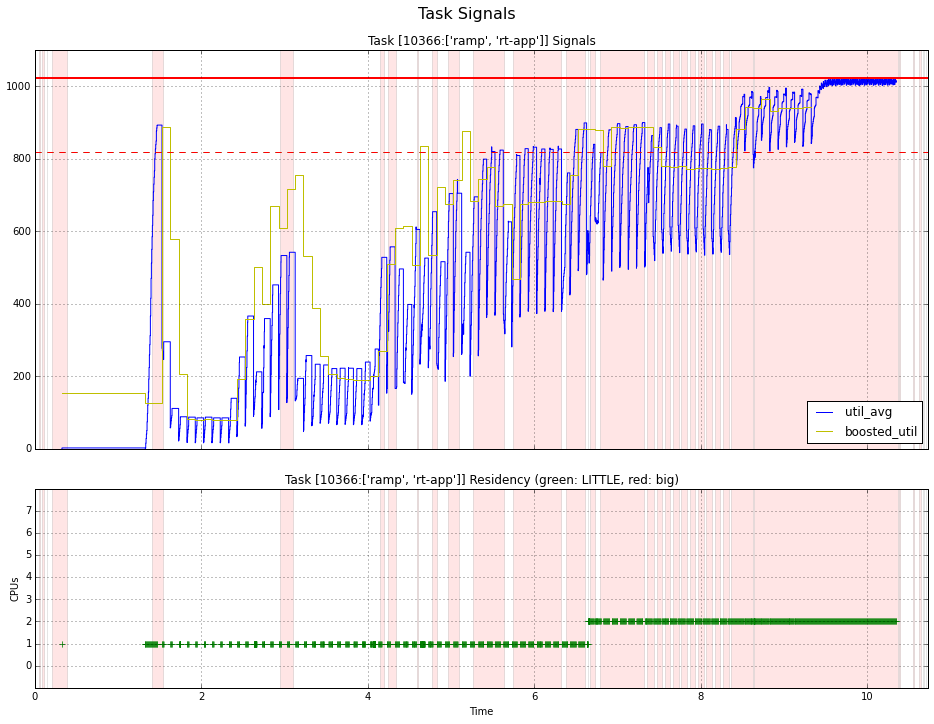

In [34]:
trace.analysis.tasks.plotTasks(tasks='ramp',
                               signals=['util_avg', 'boosted_util',
                                        'sched_overutilized', 'residencies'])

2016-09-23 18:58:32,990 INFO    : Found:    80 WAKEUP latencies
2016-09-23 18:58:33,019 INFO    : Found:   371 PREEMPT latencies
2016-09-23 18:58:33,021 INFO    : Total:   451 latency events


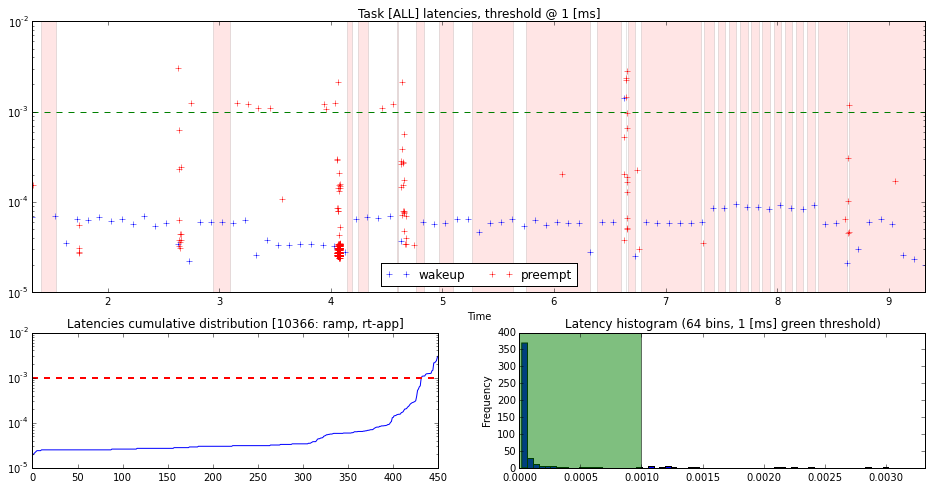

In [35]:
lat_data = trace.analysis.latency.plotLatency('ramp')

In [36]:
lat_data.T

,count,mean,std,min,50%,95%,99%,max
latency,451,0.00012,0.000347,0.000019,0.000031,0.000539,0.002132,0.003023


2016-09-23 18:58:34,935 INFO    : LITTLE cluster average frequency: 0.916 GHz
2016-09-23 18:58:34,935 INFO    : big    cluster average frequency: 0.915 GHz


(0.91643081506625346, 0.91532341938266315)

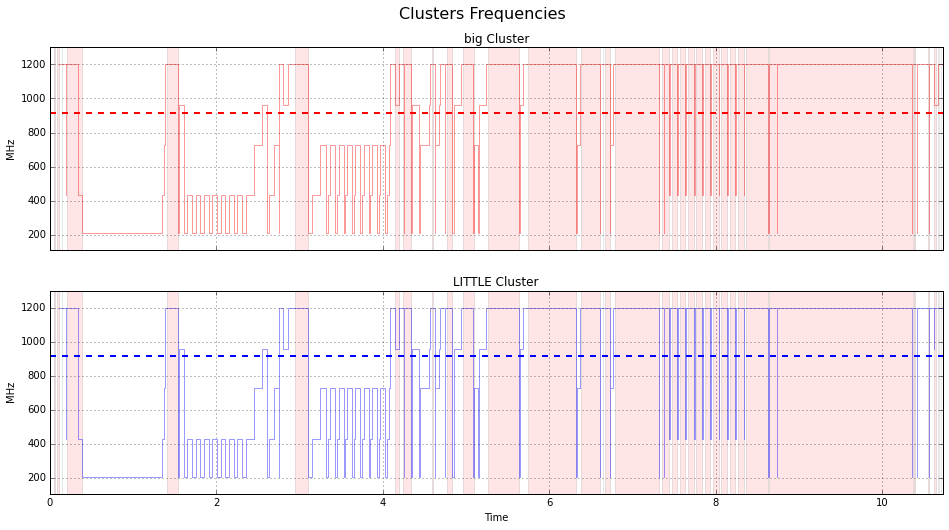

In [37]:
trace.analysis.frequency.plotClusterFrequencies()

In [38]:
trace.analysis.frequency.plotClusterFrequencyResidency(pct=True, active=True)

2016-09-23 18:58:35,119 WARNING : Cluster frequency is not coherent, plot DISABLED!


In [39]:
trace.analysis.frequency.plotClusterFrequencyResidency(pct=True, active=False)

2016-09-23 18:58:35,289 WARNING : Cluster frequency is not coherent, plot DISABLED!


# Notebooks

## New collection of examples

Each new API introduced in LISA has an associated notebook which shows a
complete example of its usage.<br>
Examples are usually defined to:

    - setup the connection to a target (usually a JUNO board)
    - configure a workload (usually using RTApp)
    - run workload and collect required measures
    - show the most common functions exposed by the new API

- Energy meters APIs:<br>
  https://github.com/ARM-software/lisa/tree/master/ipynb/examples/energy_meter

- Trace analysis APIs:<br>
  https://github.com/ARM-software/lisa/tree/master/ipynb/examples/trace_analysis